### Set up an evaluation script with a random classifier #8

Create a script that:

- Loads the dataset from `Initialize a dataset to evaluate the detection pipeline` #6
- Loads the predictions from a random classifier to classify claims using the taxonomy from `Define our contrarian claims taxonomy` #7
- Generates a text classification report
- Generates a confusion matrix plot

In [1]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from pydantic import BaseModel
from typing import Dict, List

In [2]:
class EvaluateClassifier:

    def __init__(self, classifier):
        """
        Initialize the class with a fitted classifier passed as an argument.
        :param classifier: A classification model taking a dataframe with a column "claim" as input 
        """
        self.classifier = classifier
        self._validate_classifier_input()

    def _validate_classifier_input(self):
        """
        Validate that the classifier's `predict` method accept a dataframe with a column "claim" of strings as input.
        """
        try:
            sample_input = pd.DataFrame({'claim':
                     [ 
                         "@trevorwgbiggs1 @aboutparesh Perhaps you should approach the government &amp;the elite (ones crying about climate change now) and ask them why they preferred personal dividends over a green grid, which I've been hearing we 'need' for 60 years now. I'm 61. 'We' didn't 'allow' it, all was orchestrated. Still is.",
                         "As the air's CO 2 content continues to rise, poplar trees will likely exhibit increases in growth that will shorten the time from planting to harvest and enhance their importance in the agro-forestry market. Also, with greater productivity and biomass production, significantly more carbon will be sequestered within the woody components of poplar trees and the soils in which they grow, helping to slow the rate of rise of the air's CO 2 content. Thus, the use of Populus species in managed tree plantations would appear to be a promising and prudent cultural practice for future foresters.", 
                         "Heard global warming is good for agriculture because plants like CO2?Here's a corn crop killed by heat in Texas.'Heat Wave Hits U.S. Farms, Stressing Crops and Ranchers’ Herds' by @PatThomas1318 https://t.co/dxnxooM2Za https://t.co/UrvZsrdytZ"

                    ]})
            self.classifier.predict(sample_input)
        except Exception as e:
            raise ValueError("The classifier's `predict` method must take a dataframe with a column 'claim' of strings as input. "
                             "Ensure the classifier is compatible with text data.") from e
    
    def load_data(self, file_path=None, benchmark=None):
        """
        Load data from a csv file or take directly a dataframe.

        :param file_path: Path to the Excel file containing the data
        :param benchmark: DataFrame to use directly if provided
        :return: DataFrame with the loaded data
        """
        if benchmark is None:
            benchmark = pd.read_csv(file_path)

        if 'claim' not in benchmark.columns or 'label' not in benchmark.columns:
            raise ValueError("Columns 'claim' and 'label' must be present in the benchmark")
        
        return benchmark 
    
    def predict(self, benchmark):
        """
        Predict classes on the benchmark.

        :param benchmark: Dataframe of claims
        :return: Classifier predictions
        """
        return self.classifier.predict(benchmark)
    
    def generate_classification_report(self, y, y_pred):
        """
        Generate a classification report.

        :param y: True labels
        :param y_pred: Predictions
        :return: DataFrame of the classification report
        """
        report = classification_report(y, y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        print("Classification Report:\n", report_df)
        return report_df

    def plot_confusion_matrix(self, y, y_pred, labels):
        """
        Generate and display a confusion matrix.

        :param y: True labels
        :param y_pred: Predictions
        :param categories: List of classification categories
        """
        cm = confusion_matrix(y, y_pred, labels=labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted Categories")
        plt.ylabel("True Categories")
        plt.title("Confusion Matrix")
        plt.show()

    def evaluate(self, file_path=None, benchmark=None):
        """
        Run the complete evaluation: loading benchmark, predicting  with the classifier and evaluating

        :param file_path: Path to the csv file containing the benchmark
        :param benchmark: DataFrame to use directly if provided
        """
        # Load the data
        benchmark = self.load_data(file_path, benchmark)
        y = benchmark['label']

        # Predict
        y_pred = self.predict(benchmark)
        labels = y.unique()

        # Generate the classification report
        self.generate_classification_report(y, y_pred)

        # Generate and display the confusion matrix
        self.plot_confusion_matrix(y, y_pred, labels)

In [6]:
benchmark_path = "../../data/benchmark/cards_sample_1000.csv"
df = pd.read_csv(benchmark_path)

### Test with a classifier

Test the evaluation with a random classifier and a small dataset (test).

In [3]:
import os
from dotenv import load_dotenv
from groq import Groq

import numpy as np
import json
from random import randint

load_dotenv()
os.getenv('GROQ_API_KEY')

LLAMA3_70B_INSTRUCT = "llama-3.1-70b-versatile"
DEFAULT_MODEL = LLAMA3_70B_INSTRUCT

class Claim(BaseModel):
    disinformation_score: str
    classification: str
    
class Claims(BaseModel):
    claims: list[Claim]

class Classifier():

    def __init__(self):
        self.client = Groq()

    def assistant(self, content: str):
        return { "role": "assistant", "content": content }

    def user(self, content: str):
        return { "role": "user", "content": content }

    def chat_completion(
        self,
        messages: List[Dict],
        model: str = DEFAULT_MODEL,
        temperature: float = 0.6,
        top_p: float = 0.9,
    ) -> str:
        response = self.client.chat.completions.create(
            messages=messages,
            model=model,
            temperature=temperature,
            top_p=top_p,
        )
        # print(response)
        return json.loads(response.choices[0].message.content)

    def completion(
        self,
        prompt: str,
        model: str = DEFAULT_MODEL,
        temperature: float = 0.6,
        top_p: float = 0.9,
    ) -> str:
        return self.chat_completion(
            [self.user(prompt)],
            model=model,
            temperature=temperature,
            top_p=top_p,
        )

    def classifier(
        self,
        prompt: str, 
        model: str = DEFAULT_MODEL
        )-> str:
        response = self.completion(prompt, model)
        label = response[0]['classification']
        return label

    def predict_row(self, row):
        prompt = f"""
            Tu es expert en désinformation sur les sujets environnementaux, expert en science climatique et sachant tout sur le GIEC. Je vais te donner un extrait d'une retranscription de 2 minutes d'un flux TV ou Radio. 
            A partir de cet extrait, liste moi tous les faits/opinions environnementaux (claim) uniques qu'il faudrait factchecker. Et pour chaque claim, donne une première analyse si c'est de la désinformation ou non, un score si c'est de la désinformation, ainsi qu'une catégorisation de cette allégation.
            Ne sélectionne que les claims sur les thématiques environnementales (changement climatique, transition écologique, énergie, biodiversité, pollution, pesticides, ressources (eau, minéraux, ..) et pas sur les thématiques sociales et/ou économiques
            Renvoie le résultat en json sans autre phrase d'introduction ou de conclusion avec à chaque fois les champs suivants : 

            - "disinformation_score" - le score de désinformation (voir plus bas)
            - "classification" - la classification du type de désinformation suivant la taxonomie CARDS (voir plus bas)

            Pour les scores "disinformation_score"
            - "very low" = pas de problème, l'allégation n'est pas trompeuse ou à risque. pas besoin d'investiguer plus loin
            - "low" = allégation qui nécessiterait une vérification et une interrogation, mais sur un sujet peu important et significatif dans le contexte des enjeux écologiques (exemple : les tondeuses à gazon, 
            - "medium" = allégation problématique sur un sujet écologique important (scientifique, impacts, élections, politique, transport, agriculture, énergie, alimentation, démocratie ...) , qui nécessiterait vraiment d'être vérifiée, déconstruite, débunkée et interrogée. En particulier pour les opinions fallacieuses
            - "high" = allégation grave, en particulier si elle nie le consensus scientifique

            Pour la "classification":
            - "0_accepted" = "disinformation_score" est "very low" 
            - "1_its_not_happening": "climate change is not happening"
            - "2_its_not_us": "climate change is not caused by humans"
            - "3_its_not_bad": "the consequences of climate change are not bad"
            - "4_solutions_wont_work": "the solutions won't work"
            - "5_science_is_unreliable": "climate science is unreliable"

            <transcription>
            {row['claim']}
            </transcription>
                """
        try:
            return self.classifier(prompt)
        except:
            return 'error'
        
    def predict(self, claims):
        return claims.apply(self.predict_row, axis=1)

In [7]:
test = df.iloc[[randint(1, 1000) for _ in range((50))]]
test.describe()

,claim,label,source
count,50,50,50
unique,48,6,2
top,@sussanley Thanks for nothing. No action on #C...,0_accepted,twitter
freq,2,30,33


In [9]:
classifier = Classifier()
# classifier.predict(test.iloc[:3])

349    0_accepted
333    0_accepted
333         error
dtype: object

In [10]:
evaluation = EvaluateClassifier(classifier)

/Users/anne/Desktop/Data4Good/climateguard/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anne/Desktop/Data4Good/climateguard/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anne/Desktop/Data4Good/climateguard/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report:
                          precision    recall  f1-score  support
0_accepted                0.777778  0.466667  0.583333    30.00
1_its_not_happening       0.222222  0.666667  0.333333     3.00
2_its_not_us              1.000000  0.200000  0.333333     5.00
3_its_not_bad             0.500000  0.500000  0.500000     2.00
4_solutions_wont_work     0.750000  0.500000  0.600000     6.00
5_science_is_unreliable   0.500000  0.250000  0.333333     4.00
error                     0.000000  0.000000  0.000000     0.00
accuracy                  0.440000  0.440000  0.440000     0.44
macro avg                 0.535714  0.369048  0.383333    50.00
weighted avg              0.730000  0.440000  0.522000    50.00


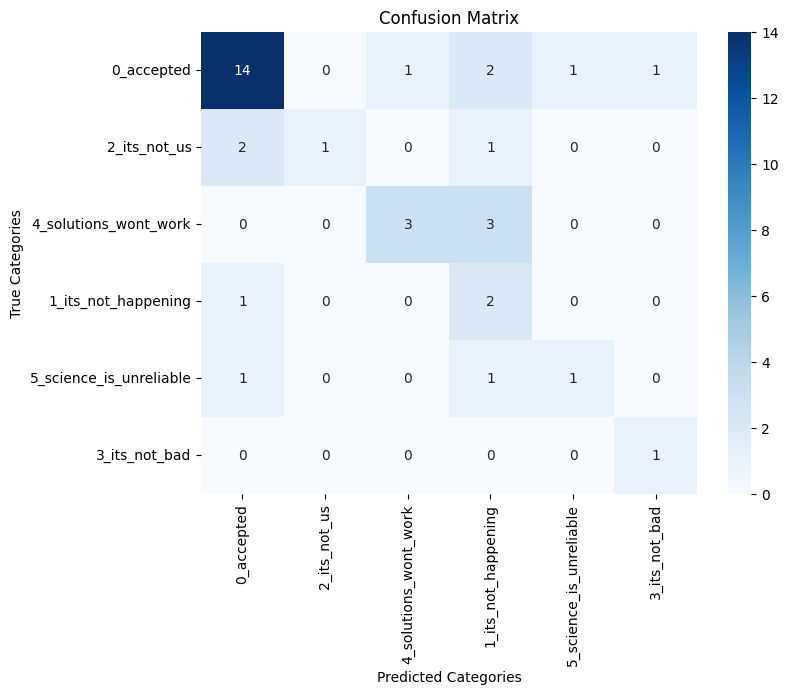

In [11]:
evaluation.evaluate(benchmark=test)